# Reinforcement Learning Basics

Every day we make decisions based on some state. If we see a red light we press the breaks. If we have an exam coming up, we study. Reinforcement Learning defines this as ```State-Action``` pairs. Given some observation you make of the environment (the state), you then make a decision (the environment). To represent all this, we typically use something known as the Markov Decision Process (MDP)

## Markov Decision Process (MDP)

The Markov Decision Process is traditionally defined by:
- a set of states $S$ that you can be in
- the set of actions $A$ that you can take at every state
- a Transition Probability model that tells you the probability of reaching a new state $S_{t+1}$ from the current state $S_t$ given that you took some action $a_t$
    - Can be written as the following: $P(S_{t+1} | S_t, a_t)$
- And a Reward Function $R(s)$ that gives you a reward for reaching some state

One of the best ways to outline this is the Frozen Lake Grid World:

![image](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/frozen_lake.gif?raw=true)

This is a game where you start at the top left corner and your goal is to get to the bottom right, but there is a catch! If while traversing your path, you happen to fall into a hole **YOU LOSE**. So lets define a couple other things here as well then:

- **start_state**: The starting state from where you begin the game
- **terminal_state**: Any state that ends the game, this is both getting to the bottom right, but also falling into the hole


#### Frozen Lake States
<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/frozen_lake_states.png?raw=true" alt="drawing" width="500"/>

In this game board, Frozen Lake is a 4x4 Grid, so we have 16 possible states that you can take. State 16 is our goal state and State 1 is our starting point. 
#### Frozen Lake Actions 
<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/frozen_lake_actions.png?raw=true" alt="drawing" width="500"/>
At each state, we can take 4 actions: 

- Move left a=0
- Move down a=1
- Move right a=2
- Move up a=3

Some caveats though, if we are in position 1 and try to go left (off of the game board) that is not allowed, we will see how we incorporate that into the MDP in a bit. 

#### Frozen Lake Rewards
<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/frozen_lake_rewards.png?raw=true" alt="drawing" width="500"/>
Every single state provides no reward except getting to our target! You get no rewards for moving around, and you definitely get no reward for falling into a hole. 

### Lets Play a Game!
To actually play these games, we will be using the Gymnasium Package. This has all sorts of games and simulations we can play with and train models on, but for now we start simple with our Frozen Lake. 

**Note**: You may need to install Gymnasium using ```pip install gymnasium```

Lets first print out our Observation and Action Spaces! Notice I use ```is_slippery``` as ```False``` for now, we will get back to that later

In [52]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

env = gym.make('FrozenLake-v1', map_name="4x4", render_mode="rgb_array", is_slippery=False)

print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Discrete(16)
Action Space: Discrete(4)


### How do we use the environment?

There are a few things we have to do to interact with this environment:
- ```env.reset()```:  This resets the environment to a new game
- ```env.step(action)```: We provide an action to the game and it takes it
- ```env.action_space.sample()```: For now we pick random actions, we will hopefully have a model later to decide the best action!


**Note**: I have a few extra lines that require input and clear the output, this is just so we can interact with the environment one step at a time and see whats happening!

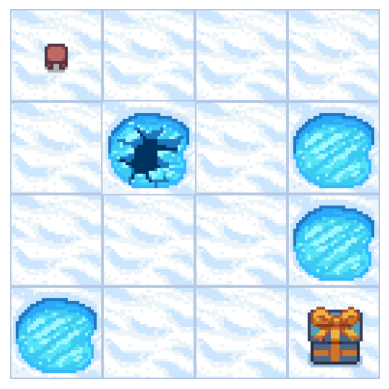

Game over. Reward: 0.0


In [58]:
# Action Mapping
action_dict = {0: "Left", 1: "Down", 2: "Right", 3: "Up"}

### Start the Game ###
observation, _ = env.reset()

# Helper to display the board
def render_board():
    plt.imshow(env.render())
    plt.axis("off")  # Hide axes for cleaner display
    plt.show()

# Display the initial board
render_board()

# Game loop
for _ in range(10):
    
    # Select a Random Action
    action = env.action_space.sample()
    print(f"Selected Action: {action_dict[action]}")

    input("Press Enter to Continue")

    # Take the action and update the environment state
    state, reward, done, _, _ = env.step(action)

    # Render the board after the action has been taken
    clear_output()
    render_board()
    
    # Check if the game has ended
    if done:
        print(f"Game over. Reward: {reward}")
        break

env.close()

#### Stochastic vs Deterministic
In a stochastic environment, I may decide to take an action, but that action may not actually occur (there is randomness). For example, if you are driving and see a red light and slam the breaks, depending on the road condition, your car may or may not stop immediately, therefore some randomness. For our first pass right now, lets focus on Deterministic, where there is no randomness in my system, I will always perform the actions I selected. 

### What Does the Deterministic MDP Look like?

The MDP is again a Tuple of, from a given state $S_t$, what is the probability I reach some other state $S_{t+1}$ given that I took some action $A$. We have one simplification right now though, that our probability is 1. What I mean by this is, If I decide to go Right from State 1, I will, with 100% probability, get to State 2. This is what the ```is_slippery``` flag controls. If the ground was slippery, then I may decide to go left, but accidentally go another direction. 



In [71]:
### Get the MDP of our Board ###
mdp = env.unwrapped.P

### Print out the MDP Tuples for the Starting Location ###
state_0_mdp = mdp[0]
state_0_mdp

{0: [(1.0, 0, 0.0, False)],
 1: [(1.0, 4, 0.0, False)],
 2: [(1.0, 1, 0.0, False)],
 3: [(1.0, 0, 0.0, False)]}

What I have done here is grab the entire MDP (provided to us by the Gymnasium Environment) and then print out the MDP for only our first starting location (top left). 

The structure of the MDP here is as follows:

```
state1: {action1:[(probability, next_state, reward, done)],
         action2:[(probability, next_state, reward, done)],
        ...}
state2: {action1:[(probability, next_state, reward, done)],
         action2:[(probability, next_state, reward, done)],
        ...}
...
```

At every state in our game, we have a dictionary of all the actions we can take. For each action we outline:
- given we take the action, what is the probability it happens
- If we take that action, what is the next state we go to
- If we take that action and go to the next state, what reward do we get
- A flag indicating if the game is over (reached the end or fell in a hole)

In [72]:
state_14_mdp = mdp[14]
state_14_mdp

{0: [(1.0, 13, 0.0, False)],
 1: [(1.0, 14, 0.0, False)],
 2: [(1.0, 15, 1.0, True)],
 3: [(1.0, 10, 0.0, False)]}

Notice if we look at state 15 (one left of our final state) and we decide to take action 2 (which is take a right) then we reach the target position, and we get a True (for end of game) but also a reward of 1

In [73]:
state_5_mdp = mdp[5]
state_5_mdp

{0: [(1.0, 5, 0, True)],
 1: [(1.0, 5, 0, True)],
 2: [(1.0, 5, 0, True)],
 3: [(1.0, 5, 0, True)]}

Similarly, if we look at the MDP for a hole, notice no matter what action we take, we are stuck in the same hole, and all have a terminal state of True so the game is over. 

### Introducing Randomness

So like I mentioned, the previous environment had a ```is_slippery``` turned off, but if we turn it on we now inject some randomness into the model. This randomness is described in the documentation:

If action is left and is_slippery is True, then:

- P(move left)=1/3
- P(move up)=1/3
- P(move down)=1/3

So with 1/3 probability you will go the direction you wanted to go, with also each with 1/3 probability you can go the other two directions (not including backwards to the selected direction)

Lets take a look at the MDP for a random environment:

In [75]:
env = gym.make('FrozenLake-v1', map_name="4x4", render_mode="rgb_array", is_slippery=True)
mdp = env.unwrapped.P

### Print out the MDP Tuples for the Starting Location ###
state_0_mdp = mdp[0]
state_0_mdp

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

### 
Our MDP Now has the following format:

```
state1: {action1:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],

         action2:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],
        ...}
state2: {action1:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],

         action2:[(probability, next_state, reward, done),
                  (probability, next_state, reward, done),
                  (probability, next_state, reward, done)],
        ...}
...
```

For example, given that we take action1 from state 1, we now have 3 possibilites we can go to, each with a 1/3 chance. Therefore we have to deliniate all those possibilities. The important part of this though is, the probabilities **MUST SUM TO 1**. If we take an action, all the probabilities of where we can end up must sum to 1, as the game has to be fully defined with no uncertanty in the rules of the game. 

## What Can We Do with an MDP?

The MDP is our best case scenario. If our world is fully defined by an MDP like this, and information about how we transition between states given our choices, we can find our optimal path to our goal using Dynamic Programming techniques which we will explore soon. The problem is, the world is not defined by an MDP, and in more complex problems with millions of states and countless actions, this dictionary would become impossible big and intractable to solve. 

### Model-Based Learning
Model-Based learning means that we are trying to solve our game **GIVEN** the MDP, so the entire environment is available to us up front and we know everything about it. This is again a gross oversimplification, which is why our end goal will be to explore **Model-Free Learning** where this information is not available. For now, there are a few techniques we can use to solve a game given its MDP, two of the most popular being:
- Policy Iteration
- Value Iteration

In this notebook, we will end by implementing Policy Iteration and then in the next one do Value Iteration. 

### What are Policies and Values?

#### Policies 
Policies are my strategy, and are typically denoted as $\pi$. You can imagine a coach running a football game. By observing the opposing team, the coach can determine which formation his team can take to potentially win. Therefore the Policy is the assignment of what Action to take given the State! If we have a good policy for our game, then we know exactly what to do at every state of the game to win! 

#### Values
When thinking of Reinforcement Learning problems, there has to be a change in your mindset a bit. Instead of thinking about problems as, *how much reward have I gotten so far*, you instead need to think of it as *how much reward do I expect to get?*

This thought process is absolutely crucial, and lets frame it with a decision:

- Option A) I will give you 5000 Dollars right now
- Option B) I will give you one dollar a day for the rest of your life. 

If you know you only have 100 days to live, then you would go with Option A, but if you are healthy and know you have decades left to live, you would go with Option B. The goal is, we want to maximize our future rewards! How we balance short-term gains vs long-term rewards is parameterized via the ```Discount Factor``` $\gamma$

The Values are then the **Expected Future Rewards**, where the rewards can be calculated as follows:

$$G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}$$

This expression has two things going on:

1) $G_t$ is the rewards I can expect to get in the future from time $t+1$ to $\infty$
2) $\gamma$ is our decay parameter, if $\gamma < 1$, then we put (exponentially) less emphasis on future times. This is how we leverage the discount factor to balance how much weight we want to put towards current rewards (low $\gamma$) vs future rewards (high $\gamma$).

Our goal is always to **MAXIMIZE THE RETURNS!!** and we will learn some methods shortly in how we can do that. But ideally, we want to find, at every state, the best actions I can take to maximize my overall returns and set myself up for success.

### Expectation and Stochasticity
I also keep saying expected, and what I mean by that is quite literally the **Expectation** (or average). Lets say we have a policy $\pi$, so for every state we know what exactly what action we will take). Lets also pretend that our world is deterministic, which means, if my policy tells me to take some action at some state, that action will occur with 100% certainty. In this situation, I can start my game, and given the MDP, calculate exactly what every states value would be by directly following the policy. 

Lets pretend for a second here that this is our policy (so for every state I have decided some action):

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/frozen_lake_policy_example.png?raw=true" alt="drawing" width="500"/>

Lets then compute the Values for the starting state (and let our discount factor be 0.9). We know the reward is 0 everywhere, except at our final goal in the bottom right:

Our trajectory (as given by this specific policy) is Right, Right, Down, Down, Down, Right. Only the final state gives us a reward of 1, so lets calculate the values in this case:

$$G_0 = 0 + 0.9 * 0 + 0.9^2 * 0 + 0.9^3 * 0 + 0.9^4 * 0 + 0.9^5 * 1$$

Now, what if our floor was slippery, and the environment is now stochastic? The policy is telling us, take the action to go right, but by accident we end up going down. 

Well, the policy is now telling us, from this new position, go down, but while doing so we could accidentally end up in the hold, or we could go down, it is random. Using this randomness, you could imagine that although the policy recommends a specific trajectory, we could accidentally go down many different trajectories due to the randomness. 

This is why we use an Expectation. The Expectation of our Values for every state is not only the trajectory recommended by the policy, but rather, an average of every possible trajectory we could end up taking, weighted by the stochasticity of the environment! Thus, our problem changes from, instead of maximizing our future rewards directly, we instead want to maximize the **EXPECTED FUTURE REWARDS**

Therefore we create something new, known as the ```Value Function```

$$V_\pi(s) = E_\pi[G_t | S_t = s]$$

This expression is a summary of everything we have talked about earlier! The Value at some state $s$ at some time $t$ given a specific policy $pi$, we compute the expecation of our future rewards (i.e. averaging over the available trajectories). 

One key thing to note here though, **WE HAVE NOT TALKED ABOUT CHANGING OR IMPROVING THE POLICY**. The policy, and the set decisions we have made for an action at every state is a constant for now. As you can imagine, our goal will be to improve the policy, and make better decisions at every state, but that doesn't happen yet. All we have done is come up with an expression to compute future rewards at every state **GIVEN A POLICY**

## Bellman Equation

You may have had some suspicion that because we have to try all the different trajectories that we can take in the game, we start to see recursion show up. This is mainly because if we can write the following:

$$G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}$$

We can then also write:

$$G_t = R_{t+1} + \gamma G_{t+1}$$

If you don't see why yet, no worries! We are about to do a derivation that will put all your concerns at ease. But lets just take this idea for now, and point out that the computation of the Returns are a recursive function. This means the computation of our Values (which is the expectation of our Returns) is also a recursive function. 

Therefore having a Recursive Expression for the Values function would be quite helpful (and make it possible to solve with the iterative methods we will look at later). This is exactly what the ```Bellman Equation``` is:

$$\text{Bellman Equation: } V_\pi(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

This function is the core of Reinforcement Learning, and it enables us to compute the cumulative reward by providing a recursive decomposition of our problem! This is crucial, because instead of trying to brute force every single trajectory you can and compute the expectation over them, you can instead represent the values as the current value (**immediate rewards**) and future values (**discounted rewards**)

The question is now, how do I tie my Value function to the Bellman Equation?

### Derivation of the Bellman Equation

Lets begin with our Values Function 

$$V_\pi(s) = E_\pi[G_t | S_t = s]$$

We can also write that:

$$G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$$
$$G_{t+1} = \sum_{k=0}^\infty \gamma^k R_{t+k+2} = R_{t+2} + \gamma R_{t+3} + \gamma^2 R_{t+4} + ...$$

We can then substitute $G_{t+1}$ into our $G_t$ equation, setting up the recursion I mentioned earlier!

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ...$$
$$G_t = R_{t+1} + \gamma G_{t+1}$$

We can then substitute this expression for $G_t$ into our Value Function

$$V_\pi(s) = E_\pi[G_t | S_t = s] = E_\pi[R_{t+1} + \gamma G_{t+1} | S_t = s]$$

And therefore, by the linearity property of expectations, we can write:

$$V_\pi(s) = E_\pi[R_{t+1} | S_t = s] + \gamma E_\pi[G_{t+1} | S_t = s]$$

Therefore, we have shown that our Values (for a specific policy) can be estimated by the sum of our Immediate rewards $R_{t+1}$ and discounted future rewards. 

#### Immediate Rewards

Lets first do our manipulation of our immediate rewards! We will be using the property that $E[a] = \sum a * p(a)$. Similarly:

$$E_\pi[R_{t+1} | S_t = s]$$
$$ = \sum_r r P(r|S_t=s)$$

where $r$ is the reward we got. But, we have to remember something crucial! The reward $r$ we get is a function of what state we were in $s$, what action we took at that state $a$ and the new state we got to $s'$. So this expression is hiding that information from us, but it is there and we can pull it out!

#### Review Marginal Probabilities

I hope you have seen marginal probabilities before, but it goes something like this:

Lets say you have some joint probability $P(x,y)$, where this returns the likelihood of both x and y happening. Well, if we want probability of just $y$, then we can sum over, or marginalize over, $x$:

$$\sum_x P(x,y) = P(x)$$

If still confused, please check the [wikipedia page](https://en.wikipedia.org/wiki/Marginal_distribution), as the visual of the table of probabilities makes this obvious. 

#### Reversing the Marginal Probability Rules

If we have some variable $x$ and also its probability $P(x)$, we can technically add a variable into our probability to create a joint probability $P(x,y)$ as long as we also sum over the variables we added in, so in this case: $\sum_y P(x,y)$. Nothing changed here, we just reversed our marginalization property. Instead of marginalizing over a variable to remove it, we add in a variable to our joint probability and then marginalize over that variable to keep it equivalent. 

So, in our case, if we know that the probability of $r$, our rewards, is also related to the action we took $a$ and the new state we go to $s'$, then lets just add them in and sum over them!

$$P(r | s) = \sum_{s'}\sum_a P(s', a, r| s)$$

This is a totally fine thing to write, because, even though we added in new variables to our joint distribution, we are summing over them again (effectively marginalizing them), so we are good to go. 


Now that we have our probability as a joint distribution of $s'$, $a$, and $r$, we want to do a little manipulation. Remember, our policies is what action we prescribe to each state, but the policy doesn't necessarily have to be a hard decision, and can be a probability of decisions. 

In our Frozen Lake Example, we have 4 decisions, Left, Right, Up and Down. In a deterministic policy, we would assign each state one of these actions, but in a stochastic policy, we will assign each state a probability vector of what action to take, like:

$$\pi(s) = [P(\text{left}), P(\text{right}), P(\text{up}), P(\text{down})]$$

Therefore, we can really represent our policy as $P(a|s)$, of the probability of taking some action given the state!

The problem is our probability is currently $P(s', a, r| s)$ not  $P(a|s)$, so can we pull this information out? Yes we can! Using Conditional probability:

#### Another Trick: Conditional Probability

Remember this from high school?

$$P(A,B) = P(A|B)P(B)$$

Well, why not let $A = s' \text{and } r$ and let $B = a$

Then:

$$P(s', a, r| s) = P(A=(s', r), B=a| s) = P(A=(s', r)| B=a, s) * P(B=a | S)$$

or more simply:

$$= P(s', r| a, s) * P(a | S)$$

Therefore, putting all our marginalizing sums back:

$$P(r | s) = \sum_{s'}\sum_a P(s', a, r| s) = \sum_{s'}\sum_a P(s', r| a, s) * P(a | s)$$

and again, $P(a | s)$ is just our policy, so we can use the typical notation $\pi(a|s)$

Finally, back into our original Expected value for the immediate rewards, 

$$E_\pi[R_{t+1} | S_t = s]$$

$$ = \sum_r r P(r|S_t=s)$$

$$ = \sum_r\sum_{s'}\sum_a r P(s', r| a, s)\pi(a|s)$$

#### Discounted Future Rewards

So our expression again for the Value Function:

$$V_\pi(s) = E_\pi[R_{t+1} | S_t = s] + \gamma E_\pi[G_{t+1} | S_t = s]$$

We have found an expression for the first term of immediate rewards $E_\pi[R_{t+1} | S_t = s]$, now we are onto the second term of discounted future rewards $\gamma E_\pi[G_{t+1} | S_t = s]$ To do this we will take a very similar approach.

In the case of $E_\pi[G_{t+1} | S_t = s]$, we can let $g$ be the random variable of the future rewards $G_{t+1}$. So just like before:

$$E_\pi[G_{t+1} | S_t = s] = \sum_g gP(g|s)$$

Now just like before, we can un-marginalize our probability $P(g|s)$, but with a small addition: Before, when we had:

$$P(r | s) = \sum_{s'}\sum_a P(s', a, r| s)$$

we unmarginalized $r$ on $s'$ and $a$, because it made sense that the reward depended on which action we took and which state we ended up on.  Now, instead of marginalizing on the current reward only, we marginalize on the cumulative future reward, which also depends on the same things, which action we took and which state we ended up on, but it also depends on what reward we got just now!

Basically, our cumulative reward for the future, depends on the reward I just got right now, so we will now unmarginalize on 3 random variables $r$, $s'$ and $a$.

$$ P(g|s) = \sum_r\sum_{s'}\sum_a P(r,s',a,g|s)$$

Again, using the Conditional Probability rule, let $A=g$ and $B=r,s',a$

Then:

$$\sum_r\sum_{s'}\sum_a P(r,s',a,g|s)$$
$$= \sum_r\sum_{s'}\sum_a P(g|r,s',a,s)P(r,s',a|s)$$

Doesn't $P(r,s',a|s)$ look familiar? We just did it earlier when we showed that $P(s', a, r| s) = P(s', r| a, s)\pi(a|s)$. In which case, lets plug it in!

$$= \sum_r\sum_{s'}\sum_a P(g|r,s',a,s)P(s', r| a, s)\pi(a|s)$$

#### Markov Property
Now a more subtle property that is crucial for this derivation. The entire assumption of Reinforcement Learning is the Markov Decision Process, and the reason we call it that is because we assume the Markov Property which states that the future only depends on the immediate past and no more. In mathematical terms, we can simplify:

$$P(X_T | X_{T-1},X_{T-2},X_{T-3}, ...) = P(X_T | X_{T-1})$$

The probability at $X_T$ only cares about what happend at the previous time step $X_{T-1}$ and nothing else. Well, if our model is supposed to be Markovian, we have a bit of a simplification we can do in $P(g|r,s',a,s)$. Remember, $g$ is future rewards starting from our new state $s'$. How we got to that state isn't really the concern of $g$. Therefore the previous state we were in, $s$, the action we took at that state $a$, and the reward we got for that action $r$ don't effect $g$. This is again only true because we did the work to move these variables into the conditional. 

Therefore we can simplify: 

$$P(g|r,s',a,s) = P(g|s')$$

And our final expression for $P(g|s)$ can be written as:

$$\sum_r\sum_{s'}\sum_a P(g|s')P(s', r| a, s)\pi(a|s)$$

Lets again plug this back into our Expectation of our future rewards:


$$E_\pi[G_{t+1} | S_t = s] = \sum_g gP(g|s)$$
$$\sum_g\sum_r\sum_{s'}\sum_a g P(g|s')P(s', r| a, s)\pi(a|s)$$

There is one other substitution we can do here:

Remember that our original Values function was defined as $V_\pi(s) = E_\pi[G_T | S_t = s] = \sum_g gP(g|s)$

Well this is assuming the we are doing the cumulative reward for time $T$, hence $G_T$. What if we just did a variable substitution, adn wanted our reward for the next step. We have moved to the new state $s'$, and now we could write:

$$V_\pi(s') = E_\pi[G_{T+1} | S_t = s] = \sum_g gP(g|s')$$

All I did here is, instead of computing the value at the current state $s$, I am computing it as if we have moved onto the next state $s'$, and therefore just iterated $T$ to $T+1$. Same formula, just calculating starting from a different time step. 

Well in our expression:

$$\sum_g\sum_r\sum_{s'}\sum_a g P(g|s')P(s', r| a, s)\pi(a|s)$$

We can substitue for $\sum_g gP(g|s')$ with just a $V_\pi(s')$

Therefore our final expression for discounted future rewards are:

$$\gamma E_\pi[G_{t+1} | S_t = s] = \gamma\sum_r\sum_{s'}\sum_a V_\pi(s') P(s', r| a, s)\pi(a|s)$$

### Put it All Together!!

We have computed our immediate rewards, and we have computed our future discounted rewards. It is now time to just put them together:

$$V_\pi(s) = E_\pi[R_{t+1} | S_t = s] + \gamma E_\pi[G_{t+1} | S_t = s]$$
$$\sum_r\sum_{s'}\sum_a r P(s', r| a, s)\pi(a,s) + \gamma\sum_r\sum_{s'}\sum_a V_\pi(s') P(s', r| a, s)\pi(a|s)$$
$$= \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

Therefore deriving our Bellman Equation!!

## Some Notes on the Bellman Equation

$$\text{Bellman Equation: } V_\pi(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$


Like mentioned before, the Bellman Equation is absolutely crucial to much of the RL literature, and from this equation we will make a bunch more, but for now I want to make a few remarks on this equation:

- Notice the sum over the actions! This is because  we want our expected reward at the end, so we have so sum over all the possible actions I could take at this specific state.
- Also notice how we have a $V_{\pi}(s')$ in our expression. This is the recursive nature of Bellman Equation, to find the value for the current state, we need to find the value of all the next states we could go to, and then again what states we could go to from there, and so on! Each extra step we take will be exponentially weighted by Gamma.
- $P(s',r|a,s)$ is provided by the MDP! The MDP tells us, like we saw before, given a state and taking an action, what is the probability of ending up in a new state $s'$ and receiving a reward $r$.

### Q Function

In the Bellman Equation, we sum over all the actions we take, but what if I want the value of a specific action at a state? Well that is our Q function. It is exactly the Bellman Equation, but instead of summing over all possible actions, we just pick one:

$$\text{Q Function: } Q_\pi(s,a) = \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

Therefore is the Q function is just the value of a single action, then the main relation between the Q function and Value function is:

$$V_\pi(s) = \sum_a \pi(a|s)Q_\pi(s,a) $$

All we are doing is summing up our Q function for all the actions I could take. If our policy was deterministic, then $\pi(a|s)$ would just be 1 for the selected action, otherwise this will be a probability distribution. 

### Optimality

#### Optimal Value Function
We have spent a lot of time looking at computing these values, and again I want to note, we want to compute the values given a **CONSTANT** policy. But the question is, how do I know what the best policy is? The best policy is one that maximizes the Values (i.e. maximizes the expected returns from every state). This would look something like this:

$$V^*(s) = \max_\pi V_\pi(s)$$

Basically, the way to definitely be correct is try every single possible policy, compute its values for every state, and keep the policy that maximizes the values. Now this would be a prohibitive calculation, for example in our simple 4x4 gridworld, where each grid location has 4 possibilities for actions. This means we would have $4^{16}$ possible combinations of policies, and there is no way to try all of them.

But we can change our approach a bit. Instead of looping over all possible policies, why not, at every state, pick the action that maxmimizes our values and utilize the recursive structure of the Bellman Equation to solve it? So we can then write 

$$V^*(s) = \max_a \sum_{s'}\sum_{r}[r + \gamma V^*_{\pi}(s')]P(s',r|a,s)$$

By recursively solving our problem, rather than attempting to evaluate all policies. An analogy for this can be:

Imagine you're solving a maze with multiple solutions, and you want the shortest one:

- Method 1) Write down all possible routes and test each to find the shortest.
- Method 2) Make decisions at every intersection of the maze, determining which will get you closer to the exit. Take a step, and again do the same process (recursion)

And the best part is, the Bellman Optimality equation guarantees that selecting the best action at a single step will result in a policy that is globally optimal. 

#### Optimal Action Function
Similarly, we can try to find our optimal $Q$ function as the following:

$$Q^*(s,a) = \max_\pi Q_\pi(s,a)$$

Remember again, $Q(s,q)$ represents the expected reward at state $s$ **GIVEN** that you took action $a$, so no longer summing over the actions we can take. An optimal policy would again be one that maximizes the expected reward at every state and for the selected action. For the same reason as before though, brute forcing through every possible policy is basically impossible, so we have to again set this up as a dynamic programming, recursive problem. 

Starting with our Q function: 

$$Q_\pi(s,a) = \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

We remind ourselves of the relationship between the $Q$ Function and the $Value$ function as outlined earlier:

$$V_\pi(s) = \sum_a \pi(a|s)Q_\pi(s,a) $$

This means the Values of the next state $s'$ can similarly be written as:

$$V_\pi(s') = \sum_{a'} \pi(a'|s')Q_\pi(s',a') $$

**Note**: We wrote $a'$ here because, the values of the next state depends on the action we take from that next state, which we call $a'$.
 
Lets go ahead and plug in this equation into our previous $Q$ function:

$$Q_\pi(s,a) = \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$
$$= \sum_{s'}\sum_{r}[r + \gamma \sum_{a'} \pi(a'|s')Q_\pi(s',a')]P(s',r|a,s)$$

Now a small mental gymnastics here:

Before, when looking at our optimal Values function, we only need to maximize over the current state (no action decided!). This means, our optimal decision at a state would be to just select the action that maximizes our future rewards!

But now, in our $Q$ function, we have selected both the current state **AND** the action we take at it. This means the only decision left for us to make is what is the next action we take $a'$ that we take at the next state $s'$. Therefore, to maximize our $Q$ function, the only way is to pick the next action $a'$ at our next state $s'$ that maximizes our future rewards. 

So in our previous expression for the $Q$ function, we wrote 

$$\sum_{a'} \pi(a'|s')Q_\pi(s',a')$$

But instead of summing over the possible future actions we can take $a'$, we instead want to pick the future action that maximizes the $Q$ function. Therefore we rewrite this as:

$$\max_{a'}Q_\pi(s',a')$$


Therefore we can write:

$$Q^*(s,a) = \sum_{s'}\sum_{r}[r + \gamma \max_{a'}Q^*_\pi(s',a')]P(s',r|a,s)$$

Again, this is directly using the recursive form of the Bellman Equation, just reapplied to the $Q$ Function!

**NOTE**: If you are confused at this point, I would recommend, writing down the Bellman Equation, the Values Optimality equation and Action Optimality equation and carefully analyze what is different bettween them! The Values optimality is just our Bellman Equation, where we replace our sum over the current actions to just picking the Max action. Similarly, the $Q$ function is again just the bellman equation, but we select the max future action.


### Bellman Optimality Equations

Therefore, we have now arrived at our Bellman Optimality Equations, which is the start of our iterative method to solve these systems:

$$V^*(s) = \max_a \sum_{s'}\sum_{r}[r + \gamma V^*_{\pi}(s')]P(s',r|a,s)$$
$$Q^*(s,a) = \sum_{s'}\sum_{r}[r + \gamma \max_{a'}Q^*_\pi(s',a')]P(s',r|a,s)$$

## Policy Iteration

Finally! We have all the mechanisms we need to actually solve our problem. Lets remind ourselves of what we have:

- Policy: What action (or probability of actions) should we take at every state?
- Values: What is the expected future rewards at every state?
- Q: What is the expected future rewards at every state, given you take a specific action?

Our end goal is to have the **Optimal Policy**, so we know the best decision to make at every state to maximize future rewards. So how can we learn the policy?

### Steps of Policy Iteration

Before we look at the math, lets lay out the intuition. There are two steps to Policy Iteration:

1) **Policy Evaluation**: Given a policy (i.e. the policy is currently a constant), compute the values for every state
2) **Policy Improvement**: For every state, using the previously computed values, compute the best action we can take at every state and update the policy with those decisions.

#### Setting up the Problem as a Linear System

Lets say we start with a worst care scenario, we will randomly initialize our Policy because we don't know anything about our environment yet. Using this policy we have to calculate our optimal Values of expected future rewards. Lets look at our Values function again:

$$V_\pi(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

Now how do we go about solving this? Well we can set up a system of equations! Lets do some more manipulation on this:

$$= \sum_a \pi(a|s)\sum_{s'}\sum_{r}rP(s',r|a,s) + \gamma \sum_a \pi(a|s)\sum_{s'}\sum_{r}V_{\pi}(s')P(s',r|a,s)$$

As we can see, this is again just a sum of our immediate rewards and discounted future rewards. So lets do the following:


##### Immediate Rewards 
Let us represent our immediate expected rewards $r$ for state $s$ under this policy $\pi$ be represented as $R_\pi(s)$ where:

$$R_\pi(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}rP(s',r|a,s)$$

##### Discounted Future Rewards
We can also do some simplification to our expression for the future rewards 

$$\gamma \sum_a \pi(a|s)\sum_{s'}\sum_{r}V_{\pi}(s')P(s',r|a,s)$$

Note that $V_{\pi}(s')$ is the future rewards, and has nothing to do with a previously recieved reward $r$, so we can first pull it out:

$$= \gamma \sum_a \pi(a|s)\sum_{s'}V_{\pi}(s')\sum_{r}P(s',r|a,s)$$

We can then go ahead and marginalize over $r$, and remove it from our expression to simplify:
$$= \gamma \sum_a \pi(a|s)\sum_{s'}V_{\pi}(s')P(s'|a,s)$$

Finally rearrange this a bit, moving our sum over actions and the policy into the sum over the next state:

$$= \gamma \sum_{s'}V_{\pi}(s')\sum_a \pi(a|s)P(s'|a,s)$$

This part of the expression is then extremely important, it represents our state transition probability!: 

$$\sum_a\pi(a|s)P(s'|a,s)$$

Remember again that $\pi(a|s)$ is just the probability $P(a|s)$, so what we really have is:

$$= \sum_aP(a|s)P(s'|a,s)$$

Using our conditional probability rules from before (where $A=s'$ and $B=a'$), we can rewrite this as:

$$= \sum_aP(s', a|s)$$

Finally, we marginalzie over a. We also add the subscript $pi$ to our transition probability matrix, to indicate this is the transitions under the current policy:

$$= P_\pi(s'|s)$$

Therefore, our final expression for our Discounted Future Rewards are:

$$= \gamma \sum_{s'}V_{\pi}(s')P_\pi(s'|s)$$

##### Putting it All Together
This is the probability of selecting action $a$ at state $s$, and then moving from state $s$ to $s'$.

Therefore we have a slightly more compact form for our Bellman Equation:

$$V_\pi(s) = R_\pi(s) + \gamma \sum_{s'}V_{\pi}(s')P_\pi(s'|s)$$

##### Moving to Matrix Form

- Let $\boldsymbol{V_\pi}$ be the vector of all state values
- Let $\boldsymbol{R_\pi}$ be the vector of all the immediate rewards
- Let $\boldsymbol{P_\pi}$ be the transition probability matrix under policy $\pi$

Notice $\sum_{s'}V_{\pi}(s')P_\pi(s'|s)$ is a dot product of our Values and Transition Matrix over the possible next state $s'$ from the initial state $s$

So, the way you can think about our equation $V_\pi(s) = R_\pi(s) + \gamma \sum_{s'}V_{\pi}(s')P_\pi(s'|s)$ is that our Values at state $s$ is the sum of the reward I just got now, and the discounted reward of the next state, weighted by the likelihood of making it to that next state! This weighting in our case can be represented as a dot product as shown earlier, and so, if we want the weighted average of Values of every state, going from the state $s$ to $s'$, we can represent that as the matrix multiplication $\boldsymbol{P_\pi}\boldsymbol{V_\pi}$. Im not going to expand much more to keep this succinct, but if confused, just write out the matrix multiplication and the operation becomes immediately obvious!

Therefore we can rewrite this all in matrix form:

$$\boldsymbol{V_\pi} = \boldsymbol{R_\pi} + \gamma\boldsymbol{P_\pi}\boldsymbol{V_\pi}$$

We can then reorganize our system of equations as:

$$(\boldsymbol{I} - \gamma\boldsymbol{P_\pi})\boldsymbol{V_\pi} = \boldsymbol{R_\pi}$$

And finally:

$$\boldsymbol{V_\pi} = (\boldsymbol{I} - \gamma\boldsymbol{P_\pi})^{-1}\boldsymbol{R_\pi}$$

Solving this system of equations is identical to solving:

$$\boldsymbol{A}\boldsymbol{X} = \boldsymbol{B}$$

Using typical matrix inversion methods (Gaussian Elimination), then this is an $n^3$ operation, where $n$ is the number of states! This becomes prohibitive for large systems. 

Instead we have to use an iterative method to solve this system! 

#### Policy Evaluation

There are a lot of iterative solvers of systems you can find (like Jacobi Iteration), but we will be using the typical iterative solution you find for Policy Evaluation:

To start, we will initialize all our values for every state as 0, and then use Policy Evaluation to compute our Values for the current Policy:

$$V_{k+1}(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_k(s')]P(s',r|a,s)$$

Where $k$ in our $V_k(s')$ is the values for the current iteration (initialized as zero) and then we compute our new $V_{k+1}(s)$. We continue iterating and updating our Values function until convergence (or change smaller than some threshold). 

Basically we do:

$$V_{1}(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_0(s')]P(s',r|a,s)$$
$$V_{2}(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_1(s')]P(s',r|a,s)$$
$$V_{3}(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_2(s')]P(s',r|a,s)$$
$$...$$
$$V_{k+1}(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_k(s')]P(s',r|a,s)$$

Repeating until:
$$|V_{k+1}(s) - V_{k}(s)| < \epsilon \quad \forall s$$

Our final result is our Values function $V$ that gives the optimal expected returns for every state, **GIVEN THE POLICY**

#### Policy Improvement

So, now we have a the Values for the current policy for each state! Now the question is, how do we use this information to update our policy to make better decisions at each state? This is where we can use the $Q$ function.

Lets again remind ourselves what the $Q$ function was:

$$Q_\pi(s,a) = \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

Notice that to calculate our $Q$ function, we need our Values for the future state $s'$. Luckily for us, we have already computed these Values in the previous stem in Policy Evaluation! So now, using that information, we can go ahead and compute $Q_\pi(s,a)$ to know the value of ever action at every state. Our best policy then will be to select the action at every state that maximizes this $Q$ value! Therefore, our updated policy can be written as:


$$\pi'(s) = arg\max_a \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s) = arg\max_a Q_\pi(s,a)$$

#### Convergence 

We will continue to switch between policy improvement, to update our policy and create a new one, and then policy evaluation, to compute the values of our new policy. If our new policy $\pi'(s)$ is the same as $\pi(s)$ (i.e. our policy is no longer changing) then this policy is our optimal policy!